In [6]:
import pandas as pd
import numpy as np
import numpy.typing as npt
import seaborn as sns
import os
import sys

from dask.diagnostics import ProgressBar
import dask.dataframe as dd
from typing import List

In [5]:
parent_dir = os.path.dirname(os.getcwd())
sys.path.insert(0, parent_dir)

In [8]:
from utils.constants import *

In [9]:
def force_int64(df, int_dtypes: List[str]):
    df_clean = df.copy()

    # Convert numeric columns to float64. This is to avoid precision loss and preserve na values.
    for col, dtypes in df_clean.dtypes.items():
        if dtypes in ['float64', 'int64']:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
            df_clean[col] = df_clean[col].astype('float64')
    
    # Drop NaN values. This step is to make sure numeric columns can be converted to int64
    df_clean = df_clean.dropna()

    # Convert int64 columns to int64
    for col in int_dtypes:
        if col not in df_clean.columns:
            continue
        df_clean[col] = df_clean[col].astype('int64')
    
    print(f'\tPartition filtered to {len(df_clean)} rows')
    return df_clean


def filter_invalid_rows_convert_dtypes(df, expected_dtypes):
    """Removes rows where any column does not match expected dtype."""
    try:
        valid_mask = pd.Series(True, index=df.index)

        for col, dtype in expected_dtypes.items():
            if col not in df.columns:
                continue

            if dtype in ["int64", "float64"]:
                numeric_mask = pd.to_numeric(df[col], errors="coerce")
                valid_mask &= numeric_mask.notna()
                if valid_mask.sum()==0: 
                    print(f'No valid rows found for column {col} with dtype {dtype}')
                    return pd.DataFrame(columns=df.columns)
            
        filtered_df = df[valid_mask].copy()

        # Convert to final dtypes
        for col, dtype in expected_dtypes.items():
            if col not in filtered_df.columns:
                continue
                
            if dtype in ["int64", "float64"]:
                filtered_df[col] = pd.to_numeric(filtered_df[col], errors="coerce")
                if dtype == "int64":
                    filtered_df[col] = filtered_df[col].astype("float64").astype("int64")
            elif dtype == "object":
                filtered_df[col] = filtered_df[col].astype(str)

        print(f'\tPartition filtered to {len(filtered_df)} rows')
        return filtered_df

    except Exception as e:
        print(f"Error in filter_invalid_rows: {str(e)}")
        return pd.DataFrame(columns=df.columns)

In [12]:
ddf = dd.read_csv(os.path.join(parent_dir, DATA_PRO, QC23_clean + CSV), 
                    encoding='utf-8',
                    engine='python',
                    blocksize="64MB",
                    on_bad_lines="skip",
                    dtype='object')
ddf = ddf[[PROBLEM_LOG_ID,
               STUDENT_USER_ID,
               ASSIGNMENT_ID,
               ASSISTMENT_ID,
               PROBLEM_ID,
               SKILL_CODE,
               SKILL_NAME,
               SKILL_BUILDER,   
               SCAFFOLD,
               PROBLEM_START_TIME,
               PROBLEM_END_TIME,
               PROBLEM_TYPE_ID,
               PROBLEM_TYPE,
               PROBLEM_ORDER,
               PROBLEM_BODY,
               ANSWER_TEXT,
               CORRECTNESS]]

In [4]:
ddf.columns

Index(['problem_log_id', 'student_user_id', 'prior_problems_count',
       'prior_pr10_avg_correctness', 'prior_5pr_avg_correctness',
       'prior_pr_avg_correctness', 'problem_set_id', 'student_class_id',
       'teacher_id', 'qc_access_date', 'assignment_id',
       'assignment_start_time', 'assignment_end_time', 'assignment_completion',
       'assistment_id', 'problem_id', 'problem_set_name', 'content_source',
       'contains_skill_builder', 'is_flat_skill_builder',
       'contains_experiment', 'is_scaffold', 'problem_type_id', 'skill_code',
       'skill_name', 'problem_type', 'problem_body', 'problem_order',
       'problem_start_time', 'problem_end_time', 'answer_text', 'correctness',
       'teacher_feedback', 'hint_count', 'bottom_hint',
       'first_action_is_attempt'],
      dtype='object')

In [13]:
int_dtypes = []
for int_col, dtypes in EXPECTED_DTYPES.items():
    if dtypes == 'int64':
        int_dtypes.append(int_col)

In [14]:
verify = ddf.get_partition(0).compute().sort_values(['problem_start_time'])


In [15]:
force_int64(filter_invalid_rows_convert_dtypes(verify, EXPECTED_DTYPES), int_dtypes)

	Partition filtered to 84024 rows
	Partition filtered to 84024 rows


,problem_log_id,student_user_id,assignment_id,assistment_id,problem_id,skill_code,skill_name,is_flat_skill_builder,is_scaffold,problem_start_time,problem_end_time,problem_type_id,problem_type,problem_order,problem_body,answer_text,correctness
70069,18484,353,1041,839699,1227755,7.EE.A.2,Understand Equivalent Expressions in Context,0,0,2019-01-08 11:24:53.868 -0500,2019-01-08 11:26:40.377 -0500,8,open_response,3,<p>What do you think the variable in each stud...,"<p><span style=""font-size: 18pt;"">The Number o...",1.000000
70070,19385,382,1043,1027686,1459651,nan,nan,0,0,2019-01-08 13:28:48.081 -0500,2019-01-08 13:29:08.545 -0500,17,algebra,2,<p>If both workers continue working at the pia...,a+4,1.000000
70071,19887,384,1040,839699,1227755,nan,nan,0,0,2019-01-08 13:48:06.946 -0500,2019-01-08 13:49:20.558 -0500,8,open_response,3,<p>What do you think the variable in each stud...,<p>B repersents the box cars and C repsents th...,1.000000
35058,22613,363,1521,839773,1438771,6.EE.B.6,Write Expressions with Variables to Solve Prob...,0,0,2019-01-09 11:43:11.673 -0500,2019-01-09 11:43:45.215 -0500,13,numeric,3,<p>Use your expression to determine how much M...,2.70,0.666667
35059,23690,404,1519,839772,1227855,nan,nan,0,0,2019-01-09 15:38:45.685 -0500,2019-01-09 15:39:11.477 -0500,13,numeric,5,<p>Use your expression to determine how long P...,1.5,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70067,167939375,546315,3670399,990623,1411728,nan,nan,0,0,2023-01-26 09:25:23.039 -0500,2023-01-26 09:25:50.167 -0500,1,choose_1,1,"<p>Without performing the calculation, estimat...",B,1.000000
70068,167997969,1194347,3669546,708423,1061144,8.EE.A.4,Apply Scientific Notation Operations,0,0,2023-01-26 14:39:07.403 -0500,2023-02-10 14:02:23.456 -0500,1,choose_1,1,<p>&nbsp;Compare 2.01 &times; 10<sup>15</sup> ...,2.01*10^15 is larger,1.000000
35055,168007853,851500,3663626,857545,1250278,6.G.A.1-1,Find the Area of Triangles,0,0,2023-01-26 15:47:46.522 -0500,2023-01-26 15:47:58.128 -0500,1,choose_1,1,<p>Darnell and Donovan are both trying to calc...,Darnell,0.000000
35056,168021327,1446783,3667898,1111630,1579276,5.NF.A.1-2,Subtract Proper Fractions with Unlike Denomina...,0,0,2023-01-26 18:59:56.933 -0500,2023-01-26 19:00:09.006 -0500,13,numeric,2,<p>Write the answer and simplify if possible.<...,1/10,1.000000


In [ ]:
verify = force_int64_expected_dtypes(filter_invalid_rows_convert_dtypes(verify, EXPECTED_DTYPES), EXPECTED_DTYPES).drop_duplicates().reset_index(drop=True)

In [74]:
verify

,problem_log_id,student_user_id,prior_problems_count,prior_pr10_avg_correctness,prior_5pr_avg_correctness,prior_pr_avg_correctness,problem_set_id,student_class_id,teacher_id,qc_access_date,...,problem_body,problem_order,problem_start_time,problem_end_time,answer_text,correctness,teacher_feedback,hint_count,bottom_hint,first_action_is_attempt
70069,18484,353,203,0.975,0.95,0.888324873096447,561287,345,342,NaN,...,<p>What do you think the variable in each stud...,3,2019-01-08 11:24:53.868 -0500,2019-01-08 11:26:40.377 -0500,"<p><span style=""font-size: 18pt;"">The Number o...",1.0,You correctly described and/or defined the var...,0,false,0
70070,19385,382,194,0.775,0.85,0.8661347517730495,562177,344,342,NaN,...,<p>If both workers continue working at the pia...,2,2019-01-08 13:28:48.081 -0500,2019-01-08 13:29:08.545 -0500,a+4,1.0,NaN,0,false,0
70071,19887,384,203,0.775,0.65,0.7491496598639457,561287,344,342,NaN,...,<p>What do you think the variable in each stud...,3,2019-01-08 13:48:06.946 -0500,2019-01-08 13:49:20.558 -0500,<p>B repersents the box cars and C repsents th...,1.0,You correctly described and/or defined the var...,0,false,0
35058,22613,363,230,0.825,0.8,0.8979820627802689,562189,345,342,NaN,...,<p>Use your expression to determine how much M...,3,2019-01-09 11:43:11.673 -0500,2019-01-09 11:43:45.215 -0500,2.70,0.6666666666666667,NaN,0,false,0
35059,23690,404,230,0.8,0.6,0.8516819571865442,562189,343,342,NaN,...,<p>Use your expression to determine how long P...,5,2019-01-09 15:38:45.685 -0500,2019-01-09 15:39:11.477 -0500,1.5,1.0,NaN,0,false,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70067,167939375,546315,640,0.8,0.8,0.8604563160823598,743874,3374606,448157,NaN,...,"<p>Without performing the calculation, estimat...",1,2023-01-26 09:25:23.039 -0500,2023-01-26 09:25:50.167 -0500,B,1.0,NaN,0,false,0
70068,167997969,1194347,535,0.70875,0.5,0.8601709401709404,375153,3323143,2863732,NaN,...,<p>&nbsp;Compare 2.01 &times; 10<sup>15</sup> ...,1,2023-01-26 14:39:07.403 -0500,2023-02-10 14:02:23.456 -0500,2.01*10^15 is larger,1.0,NaN,0,false,0
35055,168007853,851500,1701,0.8,0.8,0.7735806060606051,575544,3649662,284303,NaN,...,<p>Darnell and Donovan are both trying to calc...,1,2023-01-26 15:47:46.522 -0500,2023-01-26 15:47:58.128 -0500,Darnell,0.0,NaN,0,false,0
35056,168021327,1446783,403,0.9528571428571428,1.0,0.8701747815230957,561597,3444064,396742,NaN,...,<p>Write the answer and simplify if possible.<...,2,2023-01-26 18:59:56.933 -0500,2023-01-26 19:00:09.006 -0500,1/10,1.0,NaN,0,false,0


In [54]:
dup = df[df.duplicated(subset=[STUDENT_USER_ID, PROBLEM_ID], keep=False)][[PROBLEM_LOG_ID,
                                                                     STUDENT_USER_ID,
                                                                     PROBLEM_ID,
                                                                     'problem_start_time',
                                                                     'problem_end_time',
                                                                     CORRECTNESS]].sort_values([STUDENT_USER_ID, PROBLEM_ID])

In [55]:
dup

,problem_log_id,student_user_id,problem_id,problem_start_time,problem_end_time,correctness
70898,4251411,20028,1602647,2019-11-20 11:24:03.941 -0500,2019-11-20 11:24:19.451 -0500,1.0
70899,4251411,20028,1602647,2019-11-20 11:24:03.941 -0500,2019-11-20 11:24:19.451 -0500,1.0
267,1544291,26994,1505135,2019-09-18 13:28:19.798 -0400,2019-09-18 13:29:43.925 -0400,1.0
70362,1544291,26994,1505135,2019-09-18 13:28:19.798 -0400,2019-09-18 13:29:43.925 -0400,1.0
36555,8077209,37348,1538003,2020-03-05 10:45:16.726 -0500,2020-03-05 10:45:21.994 -0500,0.0
...,...,...,...,...,...,...
28521,109425846,1760968,1232371,2021-03-09 10:23:58.962 -0500,2021-03-09 10:24:00.615 -0500,1.0
52592,63259999,1809792,1057728,2020-10-21 10:02:34.926 -0400,2020-10-21 10:02:38.995 -0400,1.0
17611,63259999,1809792,1057728,2020-10-21 10:02:34.926 -0400,2020-10-21 10:02:38.995 -0400,1.0
17370,62356692,1850919,1574800,2020-10-19 21:12:29.244 -0400,2020-10-19 21:14:55.700 -0400,0.0


In [46]:
dup[dup[STUDENT_USER_ID] == 355]

,problem_log_id,student_user_id,problem_id,problem_start_time,problem_end_time,correctness


In [53]:
df[df[STUDENT_USER_ID] == 364516][[PROBLEM_LOG_ID,
                                                                     STUDENT_USER_ID,
                                                                     PROBLEM_ID,
                                                                     'problem_start_time',
                                                                     'problem_end_time',
                                                                     CORRECTNESS]]

,problem_log_id,student_user_id,problem_id,problem_start_time,problem_end_time,correctness
5744,21788311,364516,1811316,2020-05-02 09:36:08.177 -0400,2020-05-02 09:36:43.744 -0400,1.0
75759,21788311,364516,1811316,2020-05-02 09:36:08.177 -0400,2020-05-02 09:36:43.744 -0400,1.0


In [25]:
origin_log = len(df.sort_values(['problem_start_time']))

In [27]:
ddup_log = len(dedup_df)

print(f"original log: {origin_log}, duplicate log: {ddup_log}, {ddup_log/origin_log}")

original log: 84024, duplicate log: 83806, 0.9974055031895649


In [49]:
df[[PROBLEM_LOG_ID, 
    STUDENT_USER_ID, 
    PROBLEM_ID, 
    'problem_start_time', 
    'problem_end_time']].sort_values([STUDENT_USER_ID, PROBLEM_ID]).head(n=10)

,problem_log_id,student_user_id,problem_id,problem_start_time,problem_end_time
70069,18484,353,1227755,2019-01-08 11:24:53.868 -0500,2019-01-08 11:26:40.377 -0500
6,77554,353,1440885,2019-01-29 11:25:51.322 -0500,2019-01-29 11:27:01.288 -0500
35066,80141,355,1440885,2019-01-29 17:32:40.734 -0500,2019-01-29 17:35:25.309 -0500
29,198500,355,1460384,2019-03-07 10:48:25.319 -0500,2019-03-07 10:49:01.923 -0500
35102,281547,355,1460853,2019-04-01 11:07:33.276 -0400,2019-04-01 11:08:26.061 -0400
35104,284200,355,1460865,2019-04-01 17:15:37.664 -0400,2019-04-01 17:20:21.743 -0400
70106,211889,356,1460797,2019-03-12 11:08:11.336 -0400,2019-03-12 11:17:07.850 -0400
70088,96074,360,1441412,2019-02-01 11:27:37.805 -0500,2019-02-04 10:29:52.643 -0500
12,98708,360,1441433,2019-02-04 10:43:13.475 -0500,2019-02-04 10:43:43.563 -0500
35079,153072,360,1444980,2019-02-20 11:30:39.492 -0500,2019-02-20 11:31:49.749 -0500


In [39]:
dedup_df[[PROBLEM_LOG_ID, 
    STUDENT_USER_ID, 
    PROBLEM_ID, 
    'problem_start_time', 
    'problem_end_time']].sort_values([STUDENT_USER_ID, PROBLEM_ID])

,problem_log_id,student_user_id,problem_id,problem_start_time,problem_end_time
70069,18484,353,1227755,2019-01-08 11:24:53.868 -0500,2019-01-08 11:26:40.377 -0500
6,77554,353,1440885,2019-01-29 11:25:51.322 -0500,2019-01-29 11:27:01.288 -0500
35066,80141,355,1440885,2019-01-29 17:32:40.734 -0500,2019-01-29 17:35:25.309 -0500
29,198500,355,1460384,2019-03-07 10:48:25.319 -0500,2019-03-07 10:49:01.923 -0500
35102,281547,355,1460853,2019-04-01 11:07:33.276 -0400,2019-04-01 11:08:26.061 -0400
...,...,...,...,...,...
69207,149532673,2873098,1091611,2022-02-28 13:59:42.702 -0500,2022-02-28 13:59:52.642 -0500
34471,153884074,3230790,433345,2022-04-17 12:53:30.065 -0400,2022-04-17 12:53:50.407 -0400
69519,154112714,3274676,433054,2022-04-20 13:07:17.245 -0400,2022-04-20 13:07:55.907 -0400
34560,155074088,3278818,428325,2022-05-02 17:25:34.117 -0400,2022-05-02 17:26:05.746 -0400


In [64]:
interaction_counts = dedup_df.groupby(STUDENT_USER_ID)[PROBLEM_ID].count().sort_values(ascending=False).reset_index().rename(columns={PROBLEM_ID: 'interaction_count'})

In [65]:
interaction_counts

,student_user_id,interaction_count
0,1149398,12
1,624533,12
2,1340605,10
3,1012695,10
4,324663,10
...,...,...
61853,901269,1
61854,901295,1
61855,901306,1
61856,901311,1


### Extract problem sets grouped under `assisment_id`

In [26]:
assis_prob = over_50_ddf[['assistment_id', 'problem_id']]

with pbar:
    problem_count = assis_prob.groupby('assistment_id')['problem_id'].count().compute()
    assis_count = assis_prob.groupby('problem_id')['assistment_id'].count().compute()


[                                        ] | 0% Completed | 217.35 ms

[                                        ] | 0% Completed | 131.77 ss


ValueError: Mismatched dtypes found in `pd.read_csv`/`pd.read_table`.

+---------------+---------+----------+
| Column        | Found   | Expected |
+---------------+---------+----------+
| assistment_id | float64 | int64    |
| problem_id    | float64 | int64    |
+---------------+---------+----------+

Usually this is due to dask's dtype inference failing, and
*may* be fixed by specifying dtypes manually by adding:

dtype={'assistment_id': 'float64',
       'problem_id': 'float64'}

to the call to `read_csv`/`read_table`.

Alternatively, provide `assume_missing=True` to interpret
all unspecified integer columns as floats.

In [3]:
cleaned_df = pd.read_csv(os.path.join(PROJECT_PATH, DATA_PATH, QC_CLEANED))
body_df = pd.read_csv(os.path.join(PROJECT_PATH, DATA_PATH, PROBLEM_BODY))

In [4]:
cleaned_df

,student_user_id,problem_id,problem_type,problem_body,problem_start_time,problem_end_time,answer_text,correctness
0,853365,1227810,open_response,"<p>A baker made 9 cupcakes, each a different t...",2022-01-24 16:25:37.376000+00:00,2022-01-24 16:41:21.100000+00:00,"<p><img src=""//resources.assistments.org/fetch...",1.00
1,851282,1227810,open_response,"<p>A baker made 9 cupcakes, each a different t...",2022-01-24 22:44:06.376000+00:00,2022-01-24 23:08:31.830000+00:00,"<p><img src=""//resources.assistments.org/fetch...",1.00
2,851912,1227810,open_response,"<p>A baker made 9 cupcakes, each a different t...",2022-01-24 16:28:26.941000+00:00,2022-01-24 16:32:04.517000+00:00,"<p><img src=""//resources.assistments.org/fetch...",0.25
3,851605,1227810,open_response,"<p>A baker made 9 cupcakes, each a different t...",2022-01-24 16:27:07.366000+00:00,2022-01-24 16:37:21.626000+00:00,"<p><img src=""//resources.assistments.org/fetch...",0.25
4,1169140,1227810,open_response,"<p>A baker made 9 cupcakes, each a different t...",2020-12-10 15:50:28.154000+00:00,2020-12-10 15:51:43.829000+00:00,<p>chart is onn paper</p>,0.50
...,...,...,...,...,...,...,...,...
839147,1758916,1060364,open_response,<p>Why?</p>\n<p>&nbsp;</p>,2020-10-16 13:12:38.290000+00:00,2020-10-16 13:16:02.335000+00:00,<p>so she multiply the cost of the soda and pe...,1.00
839148,1292320,1455639,choose_1,<p>Assume △ 𝐸𝑆𝑂~ △ 𝐷𝑅𝑂. A friend stands in the...,2021-03-08 15:06:48.620000+00:00,2021-03-08 15:07:35.263000+00:00,No,1.00
839149,598652,1060364,open_response,<p>Why?</p>\n<p>&nbsp;</p>,2020-09-25 18:10:02.146000+00:00,2020-09-25 18:11:39.628000+00:00,<p>Because if you divide the cost by number of...,1.00
839150,1059532,1455639,choose_1,<p>Assume △ 𝐸𝑆𝑂~ △ 𝐷𝑅𝑂. A friend stands in the...,2020-11-10 15:51:19.734000+00:00,2020-11-10 15:51:42.070000+00:00,Yes,0.00


In [5]:
body_df

,problem_id,problem_type,problem_body
0,1227810,open_response,"<p>A baker made 9 cupcakes, each a different t..."
1,1457654,choose_1,<p>Which person&rsquo;s car will be recharged ...
2,1618756,open_response,<p>Explain your reasoning.</p>
3,1718437,choose_1,<p>Compare the&nbsp;standard deviation of the ...
4,1507771,choose_1,<p>Which event is more likely: rolling a stand...
...,...,...,...
3037,1218046,choose_1,<p>What is&nbsp;the relationship between the p...
3038,1070669,choose_1,"<p>In the diagram below, you have △𝐴𝐵𝐶 and △𝐴&..."
3039,1531509,choose_1,<p>The school store sells pencils for&nbsp;$0....
3040,1455639,choose_1,<p>Assume △ 𝐸𝑆𝑂~ △ 𝐷𝑅𝑂. A friend stands in the...


In [6]:
from bs4 import BeautifulSoup
import re
import unicodedata

In [215]:
def soup_remove_style_span(soup):
    """
    Given a html soup, get rid of the source credit.
    """
    # 
    footnote_span = soup.find_all('span', style = "font-size: 8pt;")
    if footnote_span is not None:
        for span in footnote_span:
            span.decompose()
    
    return soup

def soup_remove_url_parent(soup):
    """
    Get rid of the Source credit footter
    one example: 
    </p><p style="font-size: 10px; text-align: right">\r\n    Modified from <a href="https://www.engageny.org/" target="_blank">EngageNY</a> &copy;Great Minds <a href="https://new.assistments.org/curricula/great-minds" target="_blank">Disclaimer</a>
    """
    [a.parent.decompose() for a in soup.find_all('a') if (parent := a.parent)]
    return soup

def remove_html(content):
    """
    remove html elements.
    """
    soup = BeautifulSoup(content, 'html.parser')

    soup = soup_remove_style_span(soup)
    soup = soup_remove_url_parent(soup)
    text = soup.get_text(' ', strip=True)
    return unicodedata.normalize('NFKD', text) 


def identify_type(content):
    """
    Given a html string, classify it as 'PIX' or 'TXT depending on whether there is a 'img' class in the content.

    >>> type = identify_type(" <p><img src="/images/assistments/93900.jpg" alt="" width="134" height="49" /></p>")
    >>> type
    >>> 'PIX'
    """
    img_obj = BeautifulSoup(content, 'html.parser').find('img')
    if img_obj is not None:
        return 'PIX'
    else:
        return 'TXT'

def remove_newline(text):
    """
    given a string remove new line
    """
    return text.replace("\r\n", " ").replace("\n", " ")

In [216]:
def clean_text(content):
    text = remove_html(content)
    text = remove_newline(text)
    return text

In [217]:
# Construct two features of problem body text and body type
body_df['body_text'] = body_df['problem_body'].apply(clean_text)
body_df['body_type'] = body_df['problem_body'].apply(identify_type)

In [218]:
# text-only problems
text_df = body_df[body_df['body_type'].isin(['TXT'])]

# Multiple Choice text problems
mc_text_df = text_df[text_df['problem_type'].isin(['choose_1', 'choose_n'])].reset_index().drop(['index'], axis=1)

In [219]:
mc_text_df

,problem_id,problem_type,problem_body,body_text,body_type
0,1457654,choose_1,<p>Which person&rsquo;s car will be recharged ...,Which person’s car will be recharged to full c...,TXT
1,1718437,choose_1,<p>Compare the&nbsp;standard deviation of the ...,Compare the standard deviation of the two data...,TXT
2,1507771,choose_1,<p>Which event is more likely: rolling a stand...,Which event is more likely: rolling a standard...,TXT
3,1336411,choose_1,<p>h. Is 8 a factor of 92?</p>,h. Is 8 a factor of 92?,TXT
4,1428150,choose_1,<p>Are the two points related by a reflection ...,Are the two points related by a reflection ove...,TXT
...,...,...,...,...,...
965,1609474,choose_n,<p>b. i) Select&nbsp;<strong>all&nbsp;</strong...,b. i) Select all the expressions that represen...,TXT
966,1525414,choose_1,"<p>While playing basketball, Jada&rsquo;s hear...","While playing basketball, Jada’s heart rate go...",TXT
967,1218046,choose_1,<p>What is&nbsp;the relationship between the p...,What is the relationship between the points K ...,TXT
968,1531509,choose_1,<p>The school store sells pencils for&nbsp;$0....,"The school store sells pencils for $0.30 each,...",TXT


In [220]:
mc_text_df.groupby('problem_type')['problem_type'].count()

problem_type
choose_1    920
choose_n     50
Name: problem_type, dtype: int64

In [221]:
mc_text_df.iloc[150]['problem_body']

'<p>There are 1,525 pages in a book. Julia and Kim round the number of pages to the nearest hundred. Julia says it is one thousand, five hundred. Kim says it is 15 hundreds. Who is correct?</p>\n<p>&nbsp;</p>\n<p style="font-size: 10px; text-align: right;">Modified from <a href="https://www.engageny.org/" target="_blank" rel="noopener noreferrer">EngageNY</a> &copy;Great Minds <a href="https://new.assistments.org/curricula/great-minds" target="_blank" rel="noopener noreferrer">Disclaimer</a></p>'

In [222]:
for i, (id, text) in enumerate(zip(mc_text_df['problem_id'].to_numpy() ,mc_text_df['body_text'].to_numpy())):
    print(i, "id", id, text)

0 id 1457654 Which person’s car will be recharged to full capacity first?
1 id 1718437 Compare the standard deviation of the two data sets.
2 id 1507771 Which event is more likely: rolling a standard number cube and getting an even number, or flipping a coin and having it land heads up?
3 id 1336411 h. Is 8 a factor of 92?
4 id 1428150 Are the two points related by a reflection over an axis in the coordinate plane?
5 id 1601443 Here are three different recipes for Orangey-Pineapple Juice. Two of these mixtures taste the same and one tastes different. Recipe 1: Mix 4 cups of orange juice with 6 cups of pineapple juice. Recipe 2: Mix 6 cups of orange juice with 9 cups of pineapple juice. Recipe 3: Mix 9 cups of orange juice with 12 cups of pineapple juice. Which two recipes will taste the same?
6 id 1762491 For each interval, decide if the average rate of change is positive or negative. from 1930 to 1940
7 id 1815190 Which unit did you use?
8 id 1487446 For Service B, is the additional c

In [65]:
mc_text_CTT_interaction = cleaned_df[cleaned_df['problem_id'].isin(mc_text_df['problem_id'])].reset_index(drop=True).groupby('problem_id')['student_user_id'].count().reset_index().rename(columns={'student_user_id': 'interaction_count'})

In [67]:
mc_text_CTT_interaction.sort_values(['interaction_count'], ascending=False)

,problem_id,interaction_count
398,1501985,1964
399,1501986,1917
400,1501987,1910
672,1601443,1817
105,1214842,1803
...,...,...
466,1509134,102
780,1654199,101
889,1759494,101
697,1608838,101


In [19]:
mc_text_CTT_correctness = cleaned_df[cleaned_df['problem_id'].isin(mc_text_df['problem_id'])].reset_index(drop=True).groupby('problem_id')['correctness'].mean().reset_index()

In [74]:
mc_text_CTT_correctness.sort_values(['correctness'],ascending=False)

,problem_id,correctness
939,1815151,1.000000
944,1815201,1.000000
941,1815181,1.000000
942,1815190,1.000000
940,1815174,1.000000
...,...,...
87,1212231,0.273279
950,1869872,0.269406
572,1538861,0.230047
57,1192588,0.185328


In [53]:
mc_text_CTT_correctness['correctness'].describe()

count    970.000000
mean       0.730248
std        0.146766
min        0.183007
25%        0.639248
50%        0.748492
75%        0.846886
max        1.000000
Name: correctness, dtype: float64

<Axes: xlabel='correctness', ylabel='Count'>

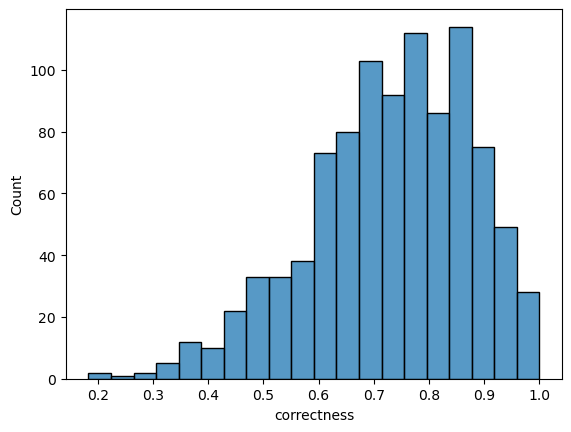

In [24]:
sns.histplot(mc_text_CTT_correctness, x='correctness')

In [ ]:
def get_correctness_dist(problem_id, data, plot_type='histplot'):
    if isinstance(problem_id, (list, np.ndarray)):
        problem = data[data['problem_id'].isin(problem_id)]
    else:
        problem = data[data['problem_id'].isin([problem_id])]
    plot_dict = dict({
        'histplot': sns.histplot,
        'kdeplot': sns.kdeplot
    })
    plot = plot_dict[plot_type]
    plot(problem, x = 'correctness')

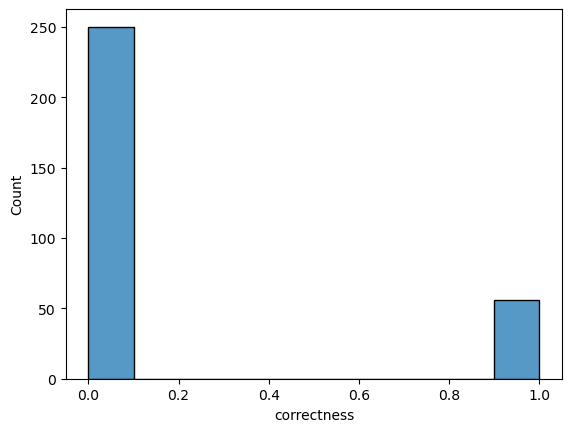

In [75]:
# choose_1 
get_correctness_dist(1066439, cleaned_df)


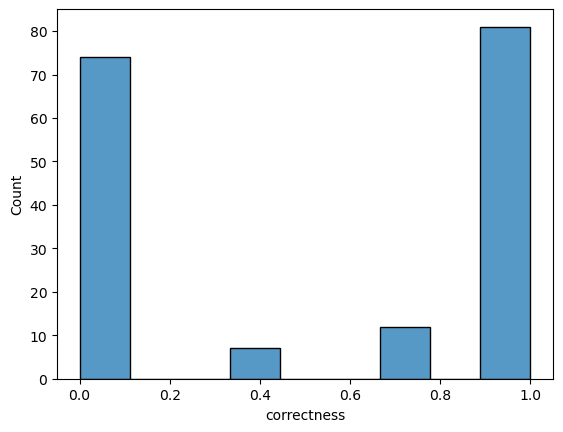

In [47]:
# choose_n
get_correctness_dist(1609474, cleaned_df)

In [214]:
# five hardest items
mc_text_df[mc_text_df['problem_id'].isin([1066439, 1192588, 1538861, 1869872, 1212231])].body_text.to_numpy()

array(['Overall, which group of students—sixth- or seventh-grade—sent more text messages?',
       'Tatiana ate 1/2 of a small carrot. Louis ate 1/4 of a large carrot. Who ate more?',
       'Luis divides 8 by 0 and says it equals 0. Is he correct?',
       'Are the pairs of corresponding angles equal in measure?',
       'Which two estimated differences are closest to the actual differences?'],
      dtype=object)

In [225]:
mc_text_df[mc_text_df['problem_id'].isin([1580275])].body_text.to_numpy()

array(['Write a statement using one of the following phrases to compare the value of the expressions. is slightly more than           is a lot more than           is slightly less than           is a lot less than Two thousand x 1.0001 _______________ two thousand'],
      dtype=object)